# Import packages

In [1]:
import os
import numpy as np
import pandas as pd
import re
import time 
import matplotlib.pyplot as plt
from collections import Counter
import copy
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pywt

# Load the data

## Creation of the structured array

In [4]:
# Define the structured array with known column names and data types
data_types = [
    ('line_of_sight', 'U4'), 
    ('train_test', 'U5'), 
    ('device', 'U9'),
    ('make', 'U9'),
    ('model', 'U28'),
    ('activity', 'U8'),
    ('experiment', 'U2'),
    ('powers_fft', 'O')
    # ,('wavelet', 'O'),
    ]
structured_array = np.empty(0, dtype=data_types)

# Function to append a row to the structured array
def add_row_to_structured_array(struct_array, **kwargs):
    new_row = np.array([tuple(
        kwargs.get(name, None) for name in struct_array.dtype.names
        )], dtype=struct_array.dtype)
    return np.append(struct_array, new_row, axis=0)

# Function to fill the array using kwargs
def fill_array(structured_array, **kwargs):
    # Directly use kwargs to construct the data dictionary
    data_to_add = [kwargs]
    
    for data in data_to_add:
        structured_array = add_row_to_structured_array(structured_array, **data)
    
    return structured_array


print(structured_array.dtype.names)
print(len(structured_array))

# # Create boolean masks for each condition
# age_25_mask = structured_array['age'] == 25
# height_6_mask = structured_array['height'] == 6.0

# # Combine the masks using the bitwise AND operator
# combined_mask = age_25_mask & height_6_mask

# # Use the boolean mask to filter the structured array
# filtered_array = structured_array[combined_mask]

# print(filtered_array)

# print(structured_array['name'])
# print(structured_array[0])

('line_of_sight', 'train_test', 'device', 'make', 'model', 'activity', 'experiment', 'powers_fft')
0


## Dataset acquiring functions 

In [7]:
def get_all_metadata(filename, dirpath):
#     print(dirpath)
    file_path = os.path.join(dirpath, filename)

    # Get the make and the model
    make_model = os.path.basename(os.path.dirname(dirpath))
    make_model_split = make_model.split("_")
    make = make_model_split[0]
    if make == "BEEBEERUN":
        model = "FPV RC drone mini quadcopter"
    else:
        model = make_model_split[1]

    # Get the activity
    activity = os.path.basename(dirpath)
    # print('\tactivity:', activity)

    # Match the experiment and capture "meta" or "data"
    regex = r"_.*?(\d{1,2})\.mat_(meta|data)\.csv"
    match = re.search(regex, filename)

    # PK: Set default values for experiment and file_type
    # experiment = None
    # file_type = None

    if match:
        experiment = match.group(1)
        file_type = match.group(2)
    else:
        None
        # print("error",filename)

    # Get the device, line_of_sight and train_test
    device = os.path.basename(os.path.dirname(os.path.dirname(dirpath)))
    # print("\tdevice",device)

    # Get the line-of-sight and wether there is Train-Test split (True for Train)
    test_train = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(dirpath))))
    if test_train not in [ "Test", "Train"]:
        # we are in NLOS
        line_of_sight = test_train
        test_train = "none"
    else:
        line_of_sight = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(dirpath)))))

    # print("\tline_of_sight", line_of_sight)
    # print("\ttest_train", test_train)
    
    # print("\texperiment", type(experiment), "  |  ",file_type)
    return file_type, make, model, activity, experiment, line_of_sight, test_train, device


def load_data(path, nth_value_only=False):

    # Load the CSV file using numpy, only reading the "Data" column
    data = np.genfromtxt(path, delimiter=',', skip_header=1, usecols=[0], dtype=float)
    # Scale to get voltage
    data = data * 6.581**(-6)

    if nth_value_only:
        data = data[::nth_value_only]

    return data

# New function to extract CWT features
def extract_features(signal, wavelet='morl', scales=np.arange(1, 51)): 
    coefficients, _ = pywt.cwt(signal, scales, wavelet)
    avg_coefficients = np.mean(np.abs(coefficients), axis=1)
    
    return avg_coefficients

# def process_signal(input_data):
#     # Calculate the Fourier Transform
#     fft = np.fft.fft(input_data)
    
#     # Calculate Power Spectral Density (PSD)
#     freqs = np.fft.fftfreq(len(input_data))
#     psd = np.abs(fft)**2 / len(input_data)

#     # Limit the Power Spectral Density to frequencies from 0 to 0.5 (needed for alignment between all datasets)
#     positive_psd = psd[(freqs >= 0) & (freqs <= 0.5)]
#     # positive_freqs = freqs[(freqs >= 0) & (freqs <= 0.5)]

# # PK
#     return positive_psd
#     # return positive_psd, positive_freqs



def iterate_folders(root_dir, structured_array, nth_value_only):
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.csv'):

                file_type, make, model, activity, experiment, line_of_sight, train_test, device = get_all_metadata(filename, dirpath)

                if file_type == "data":
                    # The actual data

                    print(dirpath)
                    print(f'train_test: {train_test}  |  make: {make}  |  model: {model}  |  activity: {activity}  |  experiment: {experiment}')
                    
                    tic = time.time()
                    # Load the signal
                    signal = load_data(dirpath + "/" + filename, nth_value_only)
                    # print(len(signal))

                    ############## FOURIER TRANSFORM ##############
                    # powers_fft = process_signal(signal)
                    # print('\tFFT is ready, power spectrum len:', len(powers_fft))
                    ###############################################

                    
                    # ############## Wavelet transform ##############
                    features = extract_features(signal)
                    # ###############################################

                    tac = time.time()
                    execution_time = tac - tic
                    print(f"\tExecution time: {execution_time:.4f} seconds")

                else:
                    # The metadata
                    continue
                
                ################
                # code to append all variables to the structured array
                structured_array = fill_array(
                structured_array, 
                line_of_sight = line_of_sight, 
                train_test = train_test, 
                device = device, 
                make = make, 
                model = model, 
                activity = activity, 
                experiment = experiment, 
                powers_fft = features
                # ,wavelet = ...
                )
                ################

                print(f"\tNow we have {len(structured_array)} samples")
                print()

    # all_data_df = pd.concat(data_frames, ignore_index=True)

    return structured_array

## Run to get the whole dataset 

In [8]:
# Get the current working directory
current_directory = os.getcwd()

# Assuming the CardRF directory is in the same folder as the current script
cardrf_directory = os.path.join(current_directory, 'data')

# Load the data
nth_value_only = False
# nth_value_only = 100

data_array = iterate_folders(cardrf_directory, structured_array, nth_value_only)

# suggestion:
# df = pd.DataFrame(data_array)

d:\Summer_school_case\data\LOS\Test\UAV\BEEBEERUN\FLYING
train_test: Test  |  make: BEEBEERUN  |  model: FPV RC drone mini quadcopter  |  activity: FLYING  |  experiment: 02
	Execution time: 16.5853 seconds
	Now we have 1 samples

d:\Summer_school_case\data\LOS\Test\UAV\BEEBEERUN\FLYING
train_test: Test  |  make: BEEBEERUN  |  model: FPV RC drone mini quadcopter  |  activity: FLYING  |  experiment: 04
	Execution time: 16.3503 seconds
	Now we have 2 samples

d:\Summer_school_case\data\LOS\Test\UAV\BEEBEERUN\FLYING
train_test: Test  |  make: BEEBEERUN  |  model: FPV RC drone mini quadcopter  |  activity: FLYING  |  experiment: 06
	Execution time: 16.4098 seconds
	Now we have 3 samples

d:\Summer_school_case\data\LOS\Test\UAV\BEEBEERUN\FLYING
train_test: Test  |  make: BEEBEERUN  |  model: FPV RC drone mini quadcopter  |  activity: FLYING  |  experiment: 09
	Execution time: 16.7391 seconds
	Now we have 4 samples

d:\Summer_school_case\data\LOS\Test\UAV\BEEBEERUN\FLYING
train_test: Test  |

In [9]:
def col_value_counts(array_col):
    col = array_col
    col_count = Counter(col)
    df = pd.DataFrame.from_dict(col_count, orient='index', columns=['count'])
    return df

In [12]:
make_model_activity = np.array([f"{row['make']} - {row['model']} - {row['activity']}" for row in data_array])


In [13]:
new_dtype = data_array.dtype.descr + [('make_model_activity', 'U100')]
new_data = np.zeros(data_array.shape, dtype=new_dtype)

for name in data_array.dtype.names:
    new_data[name] = data_array[name]

new_data['make_model_activity'] = make_model_activity

make_model = np.array([f"{row['make']} - {row['model']}" for row in new_data])

new_dtype = new_data.dtype.descr + [('make_model', 'U100')]
new_data = np.zeros(new_data.shape, dtype=new_dtype)

for name in data_array.dtype.names:
    new_data[name] = data_array[name]

new_data['make_model'] = make_model

df = col_value_counts(new_data['make_model'])
df

df = col_value_counts(new_data['make_model_activity'])
df = col_value_counts(new_data['make_model'])


In [ ]:
# def plot_all_psd_one_type(cwt_coeffs_arrays, titles):
#     plt.figure(figsize=(10, 6))
#     for coeffs in cwt_coeffs_arrays:
#         plt.plot(coeffs, label='Signal', color='blue')
#     plt.xlabel('Scale')
#     plt.ylabel('Average CWT Coefficients')
#     plt.title(f'CWT Coefficients of the Signal\n{titles} ({len(cwt_coeffs_arrays)} samples)')
#     plt.grid(True)
#     plt.show()

# for ind in df.index:
#     print(ind)
#     mask = new_data['make_model'] == ind
#     the_array = new_data[mask]
#     cwt_coeffs_arrays = the_array['cwt_coeffs']
#     plot_all_psd_one_type(cwt_coeffs_arrays, ind)

In [15]:
working_df = pd.DataFrame(new_data)
working_df['make_model_los'] = working_df['make_model'] + " - " + working_df['line_of_sight']
working_df.sort_values(by='make_model_los', inplace=True)

In [16]:
working_df.shape

(260, 11)

In [17]:
working_df.head()

,line_of_sight,train_test,device,make,model,activity,experiment,powers_fft,make_model_activity,make_model,make_model_los
0,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,02,"[0.020933194967152777, 0.016920456289763238, 0...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
40,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,01,"[0.02093748975978166, 0.016918222758591485, 0....",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
41,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,03,"[0.020935424872665167, 0.016917409308210108, 0...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
42,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,05,"[0.020932392786167497, 0.016919218879057455, 0...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
43,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,07,"[0.020925826836961578, 0.0169191444378014, 0.0...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS


In [19]:
working_df.to_pickle('working_df.pkl')

In [2]:
working_df = pd.read_pickle('working_df.pkl')
working_df.shape

(260, 11)

In [3]:
working_df.rename(columns={'powers_fft': 'cwt_coeffs'}, inplace=True)

In [4]:
list_lengths = working_df['cwt_coeffs'].apply(len)
list_lengths

0      50
40     50
41     50
42     50
43     50
       ..
242    50
241    50
240    50
248    50
259    50
Name: cwt_coeffs, Length: 260, dtype: int64

In [5]:
working_df.head()

,line_of_sight,train_test,device,make,model,activity,experiment,cwt_coeffs,make_model_activity,make_model,make_model_los
0,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,02,"[0.020933194967152777, 0.016920456289763238, 0...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
40,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,01,"[0.02093748975978166, 0.016918222758591485, 0....",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
41,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,03,"[0.020935424872665167, 0.016917409308210108, 0...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
42,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,05,"[0.020932392786167497, 0.016919218879057455, 0...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
43,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,07,"[0.020925826836961578, 0.0169191444378014, 0.0...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS


# Modelling

## Decision Tree from sklearn

### Train-Test split

In [8]:
nlos_df = working_df[working_df.line_of_sight == "NLOS"]

# Perform stratified split for NLOS
train_nlos_df, test_nlos_df = train_test_split(nlos_df, test_size=0.2, stratify=nlos_df['make_model'], random_state=42)

print("Train samples NLOS:", train_nlos_df.shape)
print("Test samples NLOS:", test_nlos_df.shape)

Train samples NLOS: (48, 11)
Test samples NLOS: (12, 11)


In [9]:
# Split the samples for LOS

train_los_df = working_df[working_df.train_test == "Train"]
test_los_df = working_df[working_df.train_test == "Test"]

print("Train samples LOS:", train_los_df.shape)
print("Test samples LOS:", test_los_df.shape)

Train samples LOS: (160, 11)
Test samples LOS: (40, 11)


In [10]:
# Concat LOS and NLOS
train_df = pd.concat([train_los_df, train_nlos_df], ignore_index=True)
test_df = pd.concat([test_los_df, test_nlos_df], ignore_index=True)
test_df

# select only needed columns
sel_col = ['make_model', 'cwt_coeffs']
train_df = train_df[sel_col]
test_df = test_df[sel_col]

### Expand coefficient list to columns for different features

In [11]:
# Expand the columns to make features
def expand_list_column(df, list_col, new_cols):
    if df[list_col].apply(len).max() > len(new_cols):
        raise ValueError("The number of new columns must be at least as many as the longest list in the column.")
    for i, col_name in enumerate(new_cols):
        df[col_name] = df[list_col].apply(lambda x: x[i] if i < len(x) else None)
    return df

new_columns = [f'feature_{i}' for i in range(1, 51)]
train_df_expanded = expand_list_column(train_df, 'cwt_coeffs', new_columns)
test_df_expanded = expand_list_column(test_df, 'cwt_coeffs', new_columns)
train_df_expanded.drop(columns="cwt_coeffs", inplace=True)
test_df_expanded.drop(columns="cwt_coeffs", inplace=True)


In [12]:
test_df_expanded.shape

(52, 51)

In [13]:
test_df_expanded.head()

,make_model,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50
0,BEEBEERUN - FPV RC drone mini quadcopter,0.020933,0.016920,0.038083,0.056058,0.183647,0.377642,0.433079,0.277642,0.104392,...,0.003758,0.006943,0.010777,0.007074,0.019528,0.009429,0.004546,0.003804,0.013485,0.006265
1,BEEBEERUN - FPV RC drone mini quadcopter,0.020933,0.016919,0.037981,0.056042,0.183772,0.377852,0.433265,0.277748,0.104429,...,0.003770,0.006950,0.010780,0.007083,0.019532,0.009424,0.004558,0.003816,0.013488,0.006266
2,BEEBEERUN - FPV RC drone mini quadcopter,0.020924,0.016918,0.037880,0.055988,0.183687,0.377830,0.433445,0.278000,0.104607,...,0.003709,0.006917,0.010751,0.007049,0.019494,0.009385,0.004495,0.003749,0.013492,0.006222
3,BEEBEERUN - FPV RC drone mini quadcopter,0.020919,0.016918,0.037722,0.055975,0.183774,0.377777,0.433103,0.277611,0.104394,...,0.003762,0.006929,0.010776,0.007072,0.019525,0.009383,0.004560,0.003820,0.013476,0.006271
4,BEEBEERUN - FPV RC drone mini quadcopter,0.020916,0.016917,0.037785,0.055956,0.183656,0.377733,0.433297,0.277866,0.104522,...,0.003738,0.006929,0.010758,0.007064,0.019499,0.009386,0.004530,0.003790,0.013493,0.006243


### Run the model

In [14]:
# Convert string labels to numerical values
label_encoder = LabelEncoder()
train_df['make_model'] = label_encoder.fit_transform(train_df['make_model'])
test_df['make_model'] = label_encoder.transform(test_df['make_model'])


# Split the data into features and target
X_train = train_df.drop('make_model', axis=1)
y_train = train_df['make_model']
X_test = test_df.drop('make_model', axis=1)
y_test = test_df['make_model']


# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 0.9230769230769231
Classification Report:
                                          precision    recall  f1-score   support

BEEBEERUN - FPV RC drone mini quadcopter       1.00      1.00      1.00         5
                           DJI - INSPIRE       0.87      0.93      0.90        14
                              DJI - M600       0.90      1.00      0.95         9
                          DJI - MAVICPRO       1.00      0.90      0.95        10
                           DJI - PHANTOM       0.92      0.86      0.89        14

                                accuracy                           0.92        52
                               macro avg       0.94      0.94      0.94        52
                            weighted avg       0.93      0.92      0.92        52



### Confusion Matrices

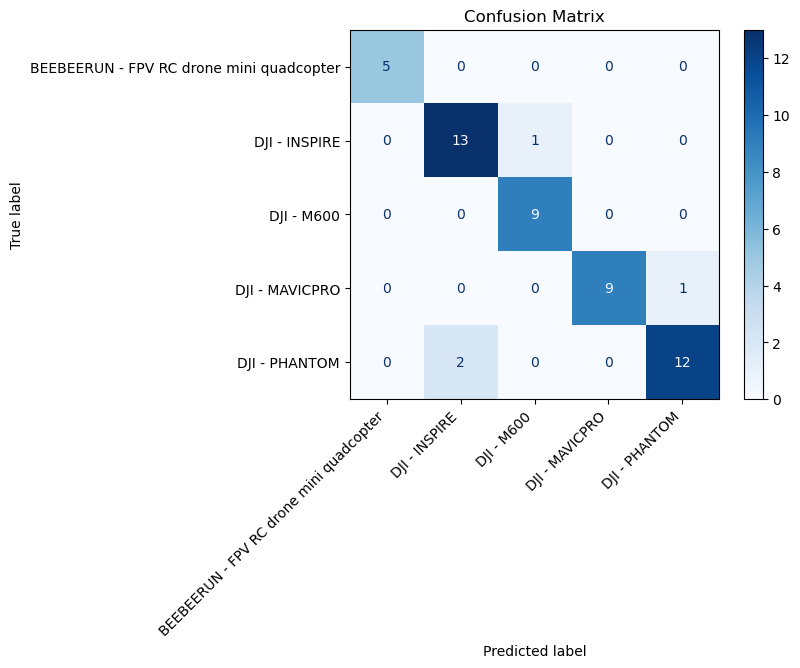

In [15]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()


Accuracy: 1.0
Classification Report:
                                          precision    recall  f1-score   support

BEEBEERUN - FPV RC drone mini quadcopter       1.00      1.00      1.00        20
                           DJI - INSPIRE       1.00      1.00      1.00        56
                              DJI - M600       1.00      1.00      1.00        36
                          DJI - MAVICPRO       1.00      1.00      1.00        40
                           DJI - PHANTOM       1.00      1.00      1.00        56

                                accuracy                           1.00       208
                               macro avg       1.00      1.00      1.00       208
                            weighted avg       1.00      1.00      1.00       208



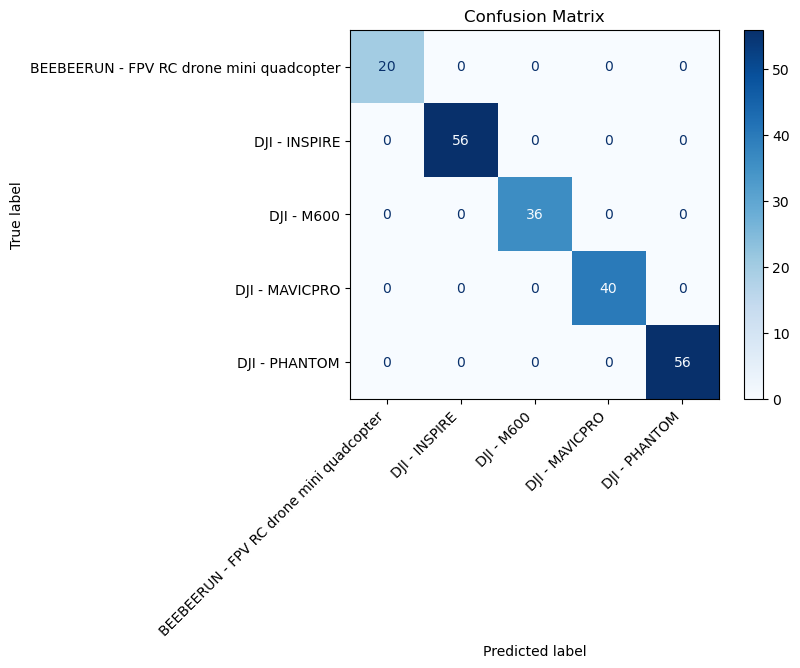

In [16]:
# Make predictions on the train set
y_pred_train = clf.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

### Display the tree

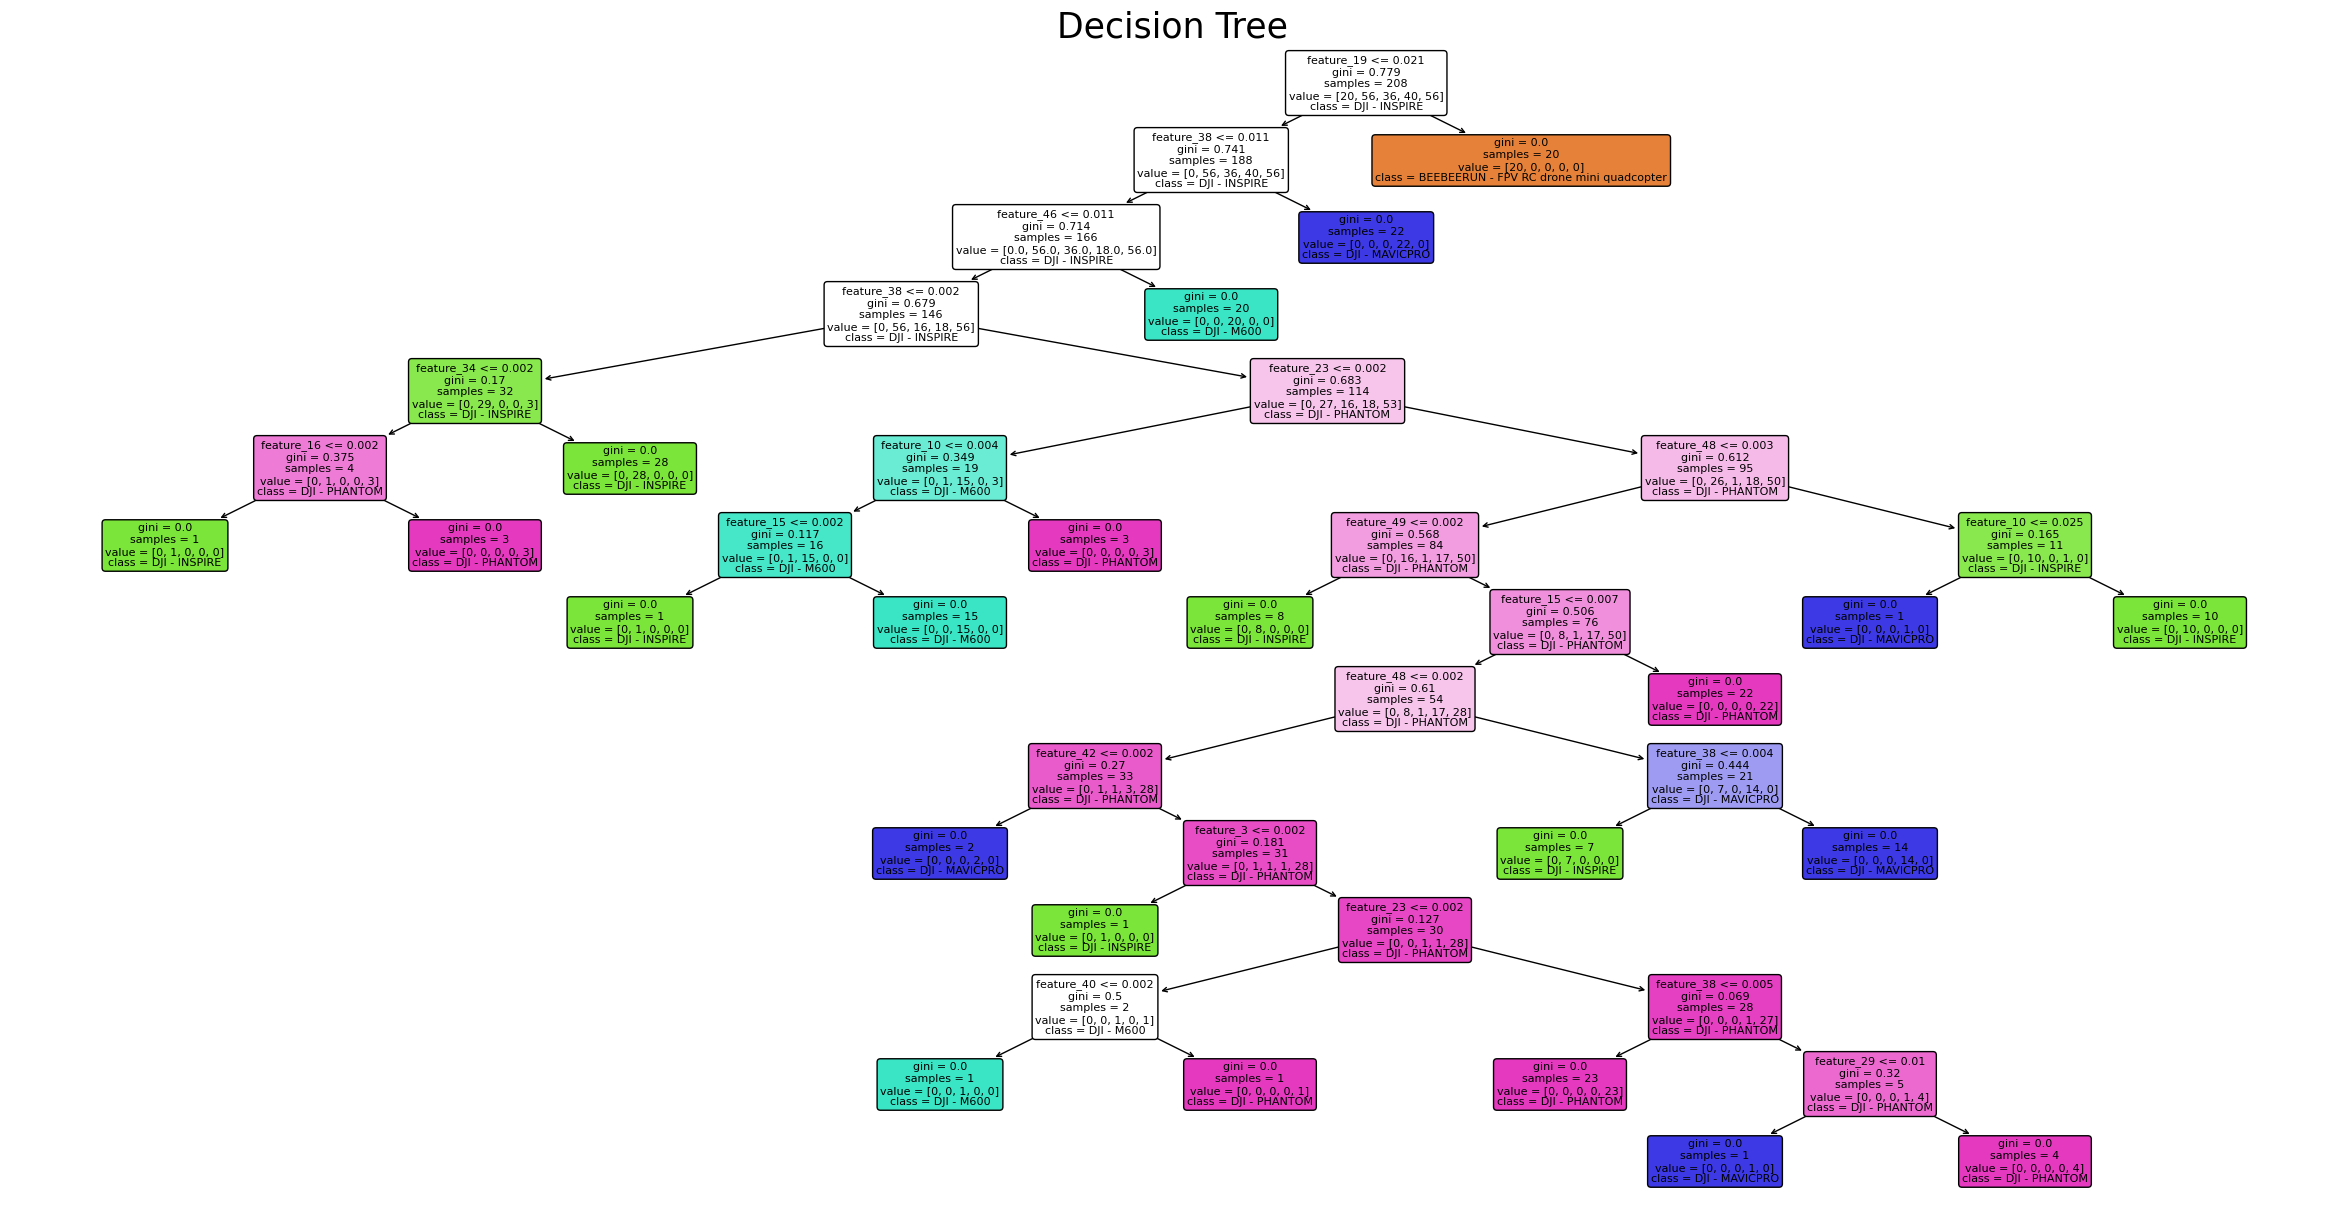

In [17]:
# Visualize the decision tree
plt.figure(figsize=(30, 15))
plot_tree(clf, feature_names=X_train.columns, class_names=label_encoder.classes_, filled=True, rounded=True, fontsize=8)
plt.title('Decision Tree', fontsize=25)
plt.show()

Classify Activities

Train samples NLOS: (48, 11)
Test samples NLOS: (12, 11)
Train samples LOS: (160, 11)
Test samples LOS: (40, 11)
Accuracy: 0.8846153846153846
Classification Report:
                                               precision    recall  f1-score   support

BEEBEERUN_FPV RC drone mini quadcopter_FLYING       1.00      1.00      1.00         5
                           DJI_INSPIRE_FLYING       0.82      1.00      0.90         9
                         DJI_INSPIRE_VIDEOING       0.83      1.00      0.91         5
                              DJI_M600_FLYING       1.00      1.00      1.00         9
                          DJI_MAVICPRO_FLYING       1.00      0.40      0.57         5
                        DJI_MAVICPRO_HOVERING       0.62      1.00      0.77         5
                           DJI_PHANTOM_FLYING       1.00      0.67      0.80         9
                         DJI_PHANTOM_HOVERING       1.00      1.00      1.00         5

                                     accuracy     

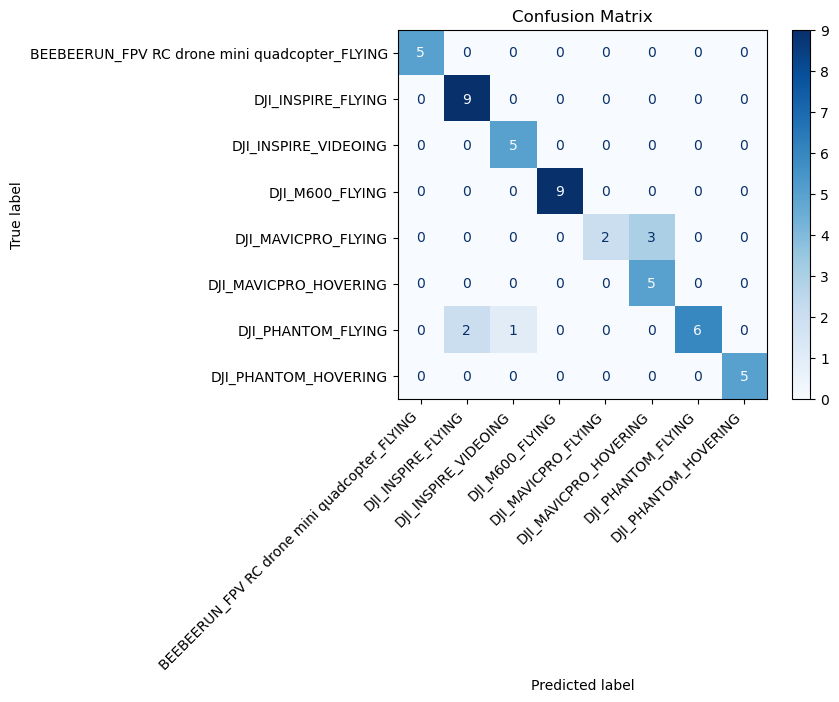

Accuracy: 1.0
Classification Report:
                                               precision    recall  f1-score   support

BEEBEERUN_FPV RC drone mini quadcopter_FLYING       1.00      1.00      1.00        20
                           DJI_INSPIRE_FLYING       1.00      1.00      1.00        36
                         DJI_INSPIRE_VIDEOING       1.00      1.00      1.00        20
                              DJI_M600_FLYING       1.00      1.00      1.00        36
                          DJI_MAVICPRO_FLYING       1.00      1.00      1.00        20
                        DJI_MAVICPRO_HOVERING       1.00      1.00      1.00        20
                           DJI_PHANTOM_FLYING       1.00      1.00      1.00        36
                         DJI_PHANTOM_HOVERING       1.00      1.00      1.00        20

                                     accuracy                           1.00       208
                                    macro avg       1.00      1.00      1.00       208
    

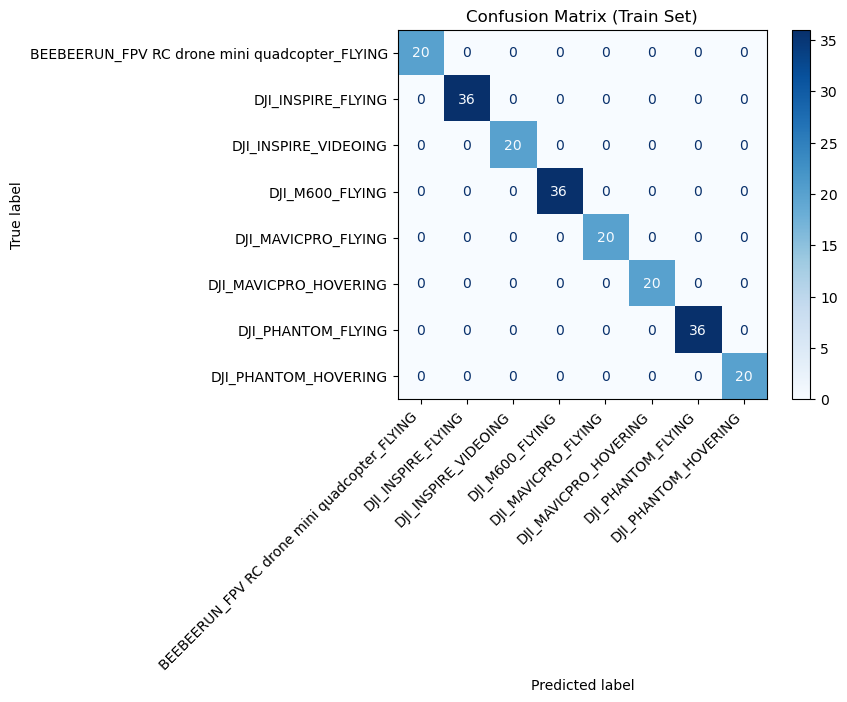

In [18]:
# Create a combined column for make, model, and activity
working_df['make_model_activity'] = working_df['make'] + "_" + working_df['model'] + "_" + working_df['activity']

# Filter NLOS data
nlos_df = working_df[working_df.line_of_sight == "NLOS"]

# Perform stratified split for NLOS
train_nlos_df, test_nlos_df = train_test_split(nlos_df, test_size=0.2, stratify=nlos_df['make_model_activity'], random_state=42)

print("Train samples NLOS:", train_nlos_df.shape)
print("Test samples NLOS:", test_nlos_df.shape)

# Split the samples for LOS
train_los_df = working_df[working_df.train_test == "Train"]
test_los_df = working_df[working_df.train_test == "Test"]

print("Train samples LOS:", train_los_df.shape)
print("Test samples LOS:", test_los_df.shape)

# Concatenate LOS and NLOS data
train_df = pd.concat([train_los_df, train_nlos_df], ignore_index=True)
test_df = pd.concat([test_los_df, test_nlos_df], ignore_index=True)

# Select only needed columns
sel_col = ['make_model_activity', 'cwt_coeffs']
train_df = train_df[sel_col]
test_df = test_df[sel_col]

# Function to expand list column into multiple feature columns
def expand_list_column(df, list_col, new_cols):
    if df[list_col].apply(len).max() > len(new_cols):
        raise ValueError("The number of new columns must be at least as many as the longest list in the column.")
    for i, col_name in enumerate(new_cols):
        df[col_name] = df[list_col].apply(lambda x: x[i] if i < len(x) else None)
    return df

new_columns = [f'feature_{i}' for i in range(1, 51)]
train_df_expanded = expand_list_column(train_df, 'cwt_coeffs', new_columns)
test_df_expanded = expand_list_column(test_df, 'cwt_coeffs', new_columns)
train_df_expanded.drop(columns="cwt_coeffs", inplace=True)
test_df_expanded.drop(columns="cwt_coeffs", inplace=True)

# Convert string labels to numerical values
label_encoder = LabelEncoder()
train_df_expanded['make_model_activity'] = label_encoder.fit_transform(train_df_expanded['make_model_activity'])
test_df_expanded['make_model_activity'] = label_encoder.transform(test_df_expanded['make_model_activity'])

# Split the data into features and target
X_train = train_df_expanded.drop('make_model_activity', axis=1)
y_train = train_df_expanded['make_model_activity']
X_test = test_df_expanded.drop('make_model_activity', axis=1)
y_test = test_df_expanded['make_model_activity']

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

# Make predictions on the train set
y_pred_train = clf.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Generate the confusion matrix for train set
cm = confusion_matrix(y_train, y_pred_train)

# Plot the confusion matrix for train set
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Train Set)')
plt.xticks(rotation=45, ha='right')
plt.show()

Classify NLOS and LOS

Train samples NLOS: (48, 12)
Test samples NLOS: (12, 12)
Train samples LOS: (160, 12)
Test samples LOS: (40, 12)
Accuracy: 0.8461538461538461
Classification Report:
                                                   precision    recall  f1-score   support

BEEBEERUN_FPV RC drone mini quadcopter_FLYING_LOS       1.00      1.00      1.00         5
                           DJI_INSPIRE_FLYING_LOS       0.71      1.00      0.83         5
                          DJI_INSPIRE_FLYING_NLOS       1.00      1.00      1.00         4
                         DJI_INSPIRE_VIDEOING_LOS       1.00      1.00      1.00         5
                              DJI_M600_FLYING_LOS       1.00      1.00      1.00         5
                             DJI_M600_FLYING_NLOS       1.00      0.75      0.86         4
                          DJI_MAVICPRO_FLYING_LOS       1.00      0.40      0.57         5
                        DJI_MAVICPRO_HOVERING_LOS       0.56      1.00      0.71         5
               

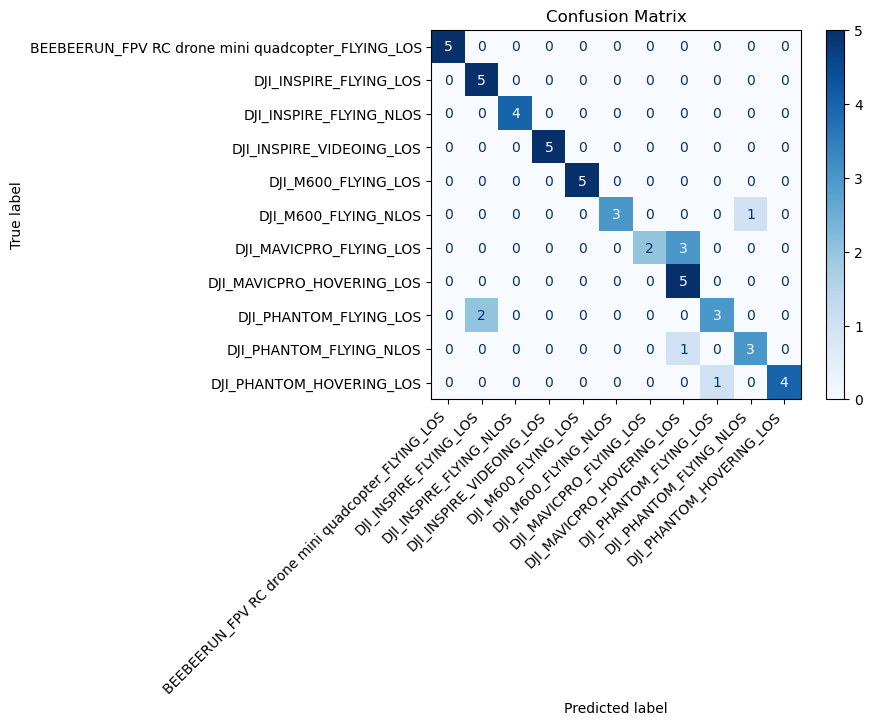

Accuracy: 1.0
Classification Report:
                                                   precision    recall  f1-score   support

BEEBEERUN_FPV RC drone mini quadcopter_FLYING_LOS       1.00      1.00      1.00        20
                           DJI_INSPIRE_FLYING_LOS       1.00      1.00      1.00        20
                          DJI_INSPIRE_FLYING_NLOS       1.00      1.00      1.00        16
                         DJI_INSPIRE_VIDEOING_LOS       1.00      1.00      1.00        20
                              DJI_M600_FLYING_LOS       1.00      1.00      1.00        20
                             DJI_M600_FLYING_NLOS       1.00      1.00      1.00        16
                          DJI_MAVICPRO_FLYING_LOS       1.00      1.00      1.00        20
                        DJI_MAVICPRO_HOVERING_LOS       1.00      1.00      1.00        20
                           DJI_PHANTOM_FLYING_LOS       1.00      1.00      1.00        20
                          DJI_PHANTOM_FLYING_NLOS   

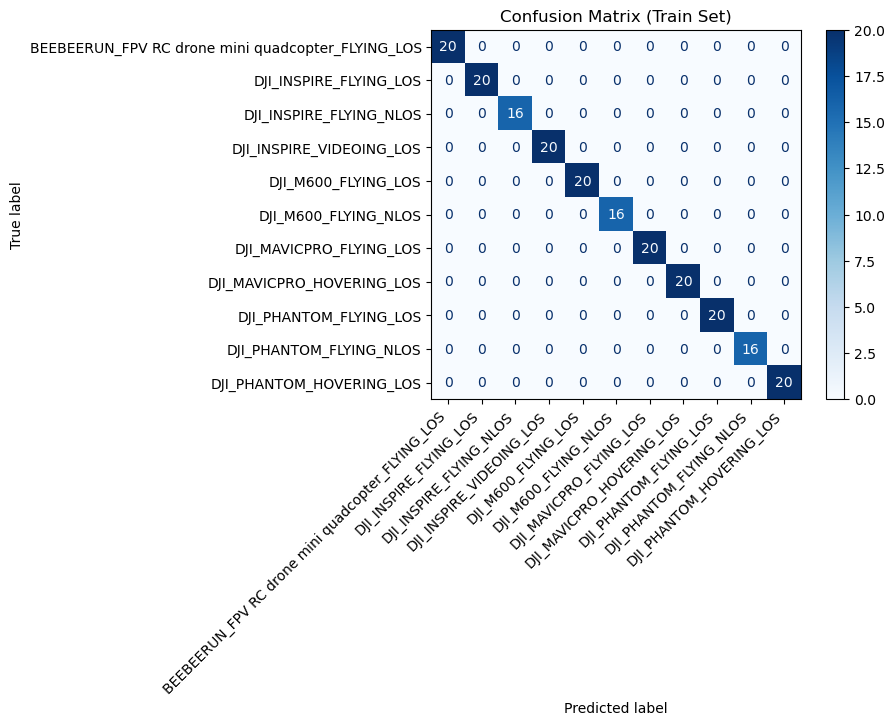

In [19]:
# Create a combined column for make, model, activity, and line_of_sight
working_df['make_model_activity_los'] = working_df['make'] + "_" + working_df['model'] + "_" + working_df['activity'] + "_" + working_df['line_of_sight']

# Filter NLOS data
nlos_df = working_df[working_df.line_of_sight == "NLOS"]

# Perform stratified split for NLOS
train_nlos_df, test_nlos_df = train_test_split(nlos_df, test_size=0.2, stratify=nlos_df['make_model_activity_los'], random_state=42)

print("Train samples NLOS:", train_nlos_df.shape)
print("Test samples NLOS:", test_nlos_df.shape)

# Split the samples for LOS
train_los_df = working_df[working_df.train_test == "Train"]
test_los_df = working_df[working_df.train_test == "Test"]

print("Train samples LOS:", train_los_df.shape)
print("Test samples LOS:", test_los_df.shape)

# Concatenate LOS and NLOS data
train_df = pd.concat([train_los_df, train_nlos_df], ignore_index=True)
test_df = pd.concat([test_los_df, test_nlos_df], ignore_index=True)

# Select only needed columns
sel_col = ['make_model_activity_los', 'cwt_coeffs']
train_df = train_df[sel_col]
test_df = test_df[sel_col]

# Function to expand list column into multiple feature columns
def expand_list_column(df, list_col, new_cols):
    if df[list_col].apply(len).max() > len(new_cols):
        raise ValueError("The number of new columns must be at least as many as the longest list in the column.")
    for i, col_name in enumerate(new_cols):
        df[col_name] = df[list_col].apply(lambda x: x[i] if i < len(x) else None)
    return df

new_columns = [f'feature_{i}' for i in range(1, 51)]
train_df_expanded = expand_list_column(train_df, 'cwt_coeffs', new_columns)
test_df_expanded = expand_list_column(test_df, 'cwt_coeffs', new_columns)
train_df_expanded.drop(columns="cwt_coeffs", inplace=True)
test_df_expanded.drop(columns="cwt_coeffs", inplace=True)

# Convert string labels to numerical values
label_encoder = LabelEncoder()
train_df_expanded['make_model_activity_los'] = label_encoder.fit_transform(train_df_expanded['make_model_activity_los'])
test_df_expanded['make_model_activity_los'] = label_encoder.transform(test_df_expanded['make_model_activity_los'])

# Split the data into features and target
X_train = train_df_expanded.drop('make_model_activity_los', axis=1)
y_train = train_df_expanded['make_model_activity_los']
X_test = test_df_expanded.drop('make_model_activity_los', axis=1)
y_test = test_df_expanded['make_model_activity_los']

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

# Make predictions on the train set
y_pred_train = clf.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Generate the confusion matrix for train set
cm = confusion_matrix(y_train, y_pred_train)

# Plot the confusion matrix for train set
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Train Set)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [20]:
train_df.shape

(208, 51)

In [21]:
test_df.shape

(52, 51)

Grid search for CWT optimization

Train samples NLOS: (48, 12)
Test samples NLOS: (12, 12)
Train samples LOS: (160, 12)
Test samples LOS: (40, 12)
Best wavelet found: mexh
Accuracy: 0.9230769230769231
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         4
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      0.75      0.86         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      0.60      0.75         5
           9       0.75      0.75      0.75         4
          10       0.83      1.00      0.91         5

    accuracy                           0.92        52
   macro avg       0.93      0.92      0.92        52
weighted avg       0.93      0.92      0.92        5

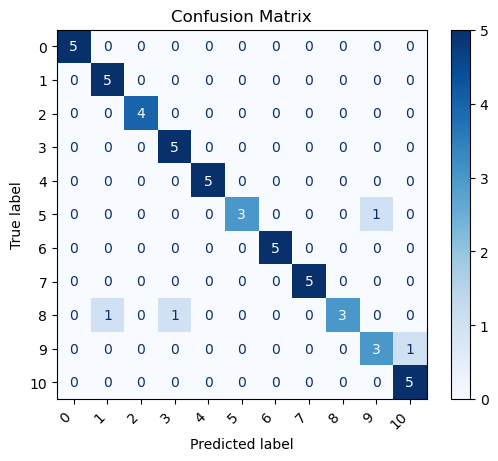

Accuracy (Train): 1.0
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        20

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208



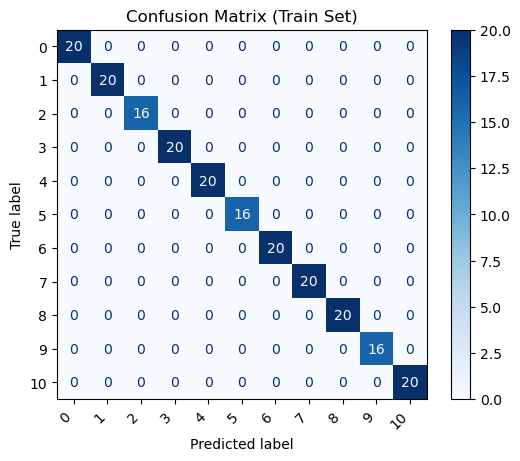

Total execution time: 2.87 seconds


In [12]:
start_time = time.time()

import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming working_df is already defined

# Create a combined column for make, model, activity, and line_of_sight
working_df['make_model_activity_los'] = (
    working_df['make'] + "_" + working_df['model'] + "_" + working_df['activity'] + "_" + working_df['line_of_sight']
)

# Filter NLOS data
nlos_df = working_df[working_df.line_of_sight == "NLOS"]

# Perform stratified split for NLOS
train_nlos_df, test_nlos_df = train_test_split(
    nlos_df, test_size=0.2, stratify=nlos_df['make_model_activity_los'], random_state=42
)

print("Train samples NLOS:", train_nlos_df.shape)
print("Test samples NLOS:", test_nlos_df.shape)

# Split the samples for LOS
train_los_df = working_df[working_df.train_test == "Train"]
test_los_df = working_df[working_df.train_test == "Test"]

print("Train samples LOS:", train_los_df.shape)
print("Test samples LOS:", test_los_df.shape)

# Concatenate LOS and NLOS data
train_df = pd.concat([train_los_df, train_nlos_df], ignore_index=True)
test_df = pd.concat([test_los_df, test_nlos_df], ignore_index=True)

# Select only needed columns
sel_col = ['make_model_activity_los', 'cwt_coeffs']
train_df = train_df[sel_col]
test_df = test_df[sel_col]

# Function to perform CWT and return coefficients
def get_cwt_coeffs(signal, wavelet, scales):
    coef, _ = pywt.cwt(signal, scales=scales, wavelet=wavelet)
    return coef.flatten()

# Function to extract features using CWT
def extract_features(df, wavelet, scales):
    cwt_features = []
    for coeffs in df['cwt_coeffs']:
        cwt_features.append(get_cwt_coeffs(coeffs, wavelet, scales))
    return pd.DataFrame(cwt_features)

# Parameter grid for grid search
param_grid = {
    'wavelet': ['morl', 'mexh', 'gaus1'],  # Morlet, Mexican hat, Gaussian
}

# Function to perform grid search and optimize CWT parameters
def grid_search_optimization(train_df, test_df, param_grid, fixed_scale):
    best_score = 0
    best_wavelet = None
    for wavelet in param_grid['wavelet']:
        train_features = extract_features(train_df, wavelet, fixed_scale)
        test_features = extract_features(test_df, wavelet, fixed_scale)

        label_encoder = LabelEncoder()
        train_df['make_model_activity_los'] = label_encoder.fit_transform(train_df['make_model_activity_los'])
        test_df['make_model_activity_los'] = label_encoder.transform(test_df['make_model_activity_los'])

        X_train = train_features
        y_train = train_df['make_model_activity_los']
        X_test = test_features
        y_test = test_df['make_model_activity_los']

        clf = DecisionTreeClassifier(random_state=42)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        if score > best_score:
            best_score = score
            best_wavelet = wavelet

    return best_wavelet

fixed_scale = np.arange(1, 51)
best_wavelet = grid_search_optimization(train_df, test_df, param_grid, fixed_scale)

print(f"Best wavelet found: {best_wavelet}")

# Extracting features and preparing the data
train_features = extract_features(train_df, best_wavelet, fixed_scale)
test_features = extract_features(test_df, best_wavelet, fixed_scale)

label_encoder = LabelEncoder()
train_df['make_model_activity_los'] = label_encoder.fit_transform(train_df['make_model_activity_los'])
test_df['make_model_activity_los'] = label_encoder.transform(test_df['make_model_activity_los'])

X_train = train_features
y_train = train_df['make_model_activity_los']
X_test = test_features
y_test = test_df['make_model_activity_los']

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

# Convert label_encoder.classes_ to string for target_names
actual_labels = list(map(str, label_encoder.classes_))

# Classification report with actual target names
report = classification_report(y_test, y_pred, target_names=actual_labels)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Confusion matrix with actual target labels
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actual_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

# Predictions and accuracy on the training set
y_pred_train = clf.predict(X_train)

accuracy_train = accuracy_score(y_train, y_pred_train)
report_train = classification_report(y_train, y_pred_train, target_names=actual_labels)

print(f'Accuracy (Train): {accuracy_train}')
print('Classification Report (Train):')
print(report_train)

# Confusion matrix for the training set with actual target labels
cm_train = confusion_matrix(y_train, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=actual_labels)
disp_train.plot(cmap='Blues')
plt.title('Confusion Matrix (Train Set)')
plt.xticks(rotation=45, ha='right')
plt.show()

end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Train samples NLOS: (48, 12)
Test samples NLOS: (12, 12)
Train samples LOS: (160, 12)
Test samples LOS: (40, 12)
Best wavelet found: mexh
Best scales found: 50
Accuracy: 0.9230769230769231
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         4
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      0.75      0.86         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      0.60      0.75         5
           9       0.75      0.75      0.75         4
          10       0.83      1.00      0.91         5

    accuracy                           0.92        52
   macro avg       0.93      0.92      0.92        52
weighted avg       0.93      0

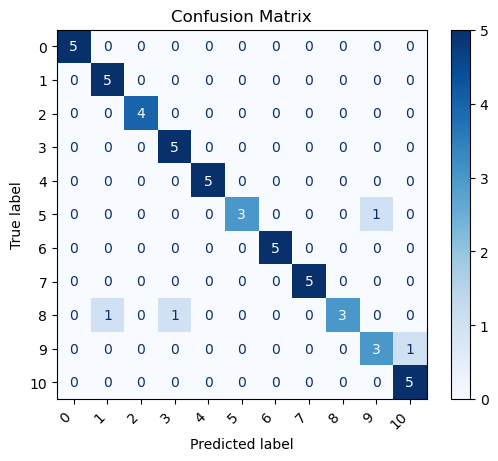

Accuracy (Train): 1.0
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        20

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208



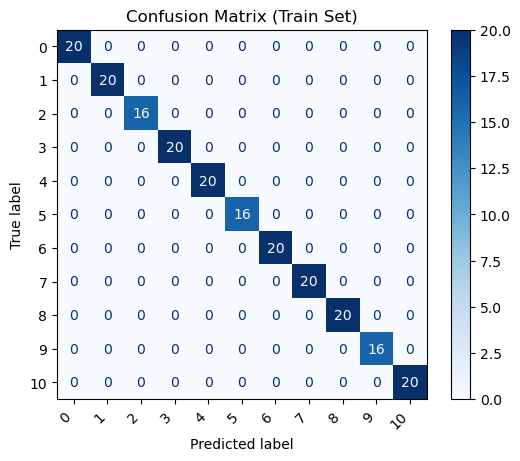

Total execution time: 10.70 seconds


In [19]:
# below is for scale as well as wavelet
import time
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

start_time = time.time()

# Assuming working_df is already defined

# Create a combined column for make, model, activity, and line_of_sight
working_df['make_model_activity_los'] = (
    working_df['make'] + "_" + working_df['model'] + "_" + working_df['activity'] + "_" + working_df['line_of_sight']
)

# Filter NLOS data
nlos_df = working_df[working_df.line_of_sight == "NLOS"]

# Perform stratified split for NLOS
train_nlos_df, test_nlos_df = train_test_split(
    nlos_df, test_size=0.2, stratify=nlos_df['make_model_activity_los'], random_state=42
)

print("Train samples NLOS:", train_nlos_df.shape)
print("Test samples NLOS:", test_nlos_df.shape)

# Split the samples for LOS
train_los_df = working_df[working_df.train_test == "Train"]
test_los_df = working_df[working_df.train_test == "Test"]

print("Train samples LOS:", train_los_df.shape)
print("Test samples LOS:", test_los_df.shape)

# Concatenate LOS and NLOS data
train_df = pd.concat([train_los_df, train_nlos_df], ignore_index=True)
test_df = pd.concat([test_los_df, test_nlos_df], ignore_index=True)

# Select only needed columns
sel_col = ['make_model_activity_los', 'cwt_coeffs']
train_df = train_df[sel_col]
test_df = test_df[sel_col]

# Function to perform CWT and return coefficients
def get_cwt_coeffs(signal, wavelet, scales):
    coef, _ = pywt.cwt(signal, scales=scales, wavelet=wavelet)
    return coef.flatten()

# Function to extract features using CWT
def extract_features(df, wavelet, scales):
    cwt_features = []
    for coeffs in df['cwt_coeffs']:
        cwt_features.append(get_cwt_coeffs(coeffs, wavelet, scales))
    return pd.DataFrame(cwt_features)

# Parameter grid for grid search
param_grid = {
    'wavelet': ['morl', 'mexh', 'gaus1'],  # Morlet, Mexican hat, Gaussian
    'scales': [50, 60, 70, 80]  # Different scales
}

# Function to perform grid search and optimize CWT parameters
def grid_search_optimization(train_df, test_df, param_grid):
    best_score = 0
    best_wavelet = None
    best_scales = None

    for wavelet in param_grid['wavelet']:
        for scales in param_grid['scales']:
            train_features = extract_features(train_df, wavelet, np.arange(1, scales+1))
            test_features = extract_features(test_df, wavelet, np.arange(1, scales+1))

            label_encoder = LabelEncoder()
            train_df['make_model_activity_los'] = label_encoder.fit_transform(train_df['make_model_activity_los'])
            test_df['make_model_activity_los'] = label_encoder.transform(test_df['make_model_activity_los'])

            X_train = train_features
            y_train = train_df['make_model_activity_los']
            X_test = test_features
            y_test = test_df['make_model_activity_los']

            clf = DecisionTreeClassifier(random_state=42)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            if score > best_score:
                best_score = score
                best_wavelet = wavelet
                best_scales = np.arange(1, scales+1)

    return best_wavelet, best_scales

best_wavelet, best_scales = grid_search_optimization(train_df, test_df, param_grid)

print(f"Best wavelet found: {best_wavelet}")
print(f"Best scales found: {len(best_scales)}")

# Extracting features and preparing the data with best parameters
train_features = extract_features(train_df, best_wavelet, best_scales)
test_features = extract_features(test_df, best_wavelet, best_scales)

label_encoder = LabelEncoder()
train_df['make_model_activity_los'] = label_encoder.fit_transform(train_df['make_model_activity_los'])
test_df['make_model_activity_los'] = label_encoder.transform(test_df['make_model_activity_los'])

X_train = train_features
y_train = train_df['make_model_activity_los']
X_test = test_features
y_test = test_df['make_model_activity_los']

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

# Convert label_encoder.classes_ to string for target_names
actual_labels = list(map(str, label_encoder.classes_))

# Classification report with actual target names
report = classification_report(y_test, y_pred, target_names=actual_labels)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Confusion matrix with actual target labels
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actual_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

# Predictions and accuracy on the training set
y_pred_train = clf.predict(X_train)

accuracy_train = accuracy_score(y_train, y_pred_train)
report_train = classification_report(y_train, y_pred_train, target_names=actual_labels)

print(f'Accuracy (Train): {accuracy_train}')
print('Classification Report (Train):')
print(report_train)

# Confusion matrix for the training set with actual target labels
cm_train = confusion_matrix(y_train, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=actual_labels)
disp_train.plot(cmap='Blues')
plt.title('Confusion Matrix (Train Set)')
plt.xticks(rotation=45, ha='right')
plt.show()

end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")